In [12]:
import numpy as np
import matplotlib.pyplot as plt
from K_Means import K_Means_Clustering
import PIL.Image
from sklearn.neighbors import NearestNeighbors

In [13]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.21, 0.72, 0.07])

def patchify(img, patch_shape):
    # Image as a contiguous array
    img = np.ascontiguousarray(img)
    # Storing shapes
    X, Y = img.shape
    x, y = patch_shape
    shape = ((X-x+1), (Y-y+1), x, y)
    # Defining stride. It is 1 currently
    strides = img.itemsize*np.array([Y, 1, Y, 1])
    # Using np stride tricks library to generate patches
    return np.lib.stride_tricks.as_strided(img, shape=shape, strides=strides)

In [14]:
# Class to perform tasks. This isn't used extensively going forward
class Coloring:
    def __init__(self, img_path):
        # Converting rgba(4 layers) image to rgb
        rgba_image = PIL.Image.open(img_path)
        rgb_image = rgba_image.convert('RGB')
        self.img = np.array(rgb_image)
        # Using the function to create a grey-scale image
        gray = rgb2gray(self.img)
        # Left actual image(colored)
        self.left_actual = self.img[:, :int(self.img.shape[1] / 2), :]
        # Right actual image(colored)
        self.right_actual = self.img[:, int(self.img.shape[1] / 2):, :]
        # Storing right shape
        self.right_actual_shape = self.img[:, int(self.img.shape[1] / 2):, :].shape
        # Grey-scale left half and right half
        self.left_half = gray[:, :int(self.img.shape[1] / 2)]
        self.right_half = gray[:, int(self.img.shape[1] / 2):]

    # Using K means
    def k_means(self, img_part, num_clusters):
        # Flattening the array
        flattened = img_part.reshape((-1, 3))
        # Using the K means class to generate clusters
        kmeans = K_Means_Clustering(k=num_clusters, max_iter=1000, tol=0.001)
        kmeans.fit(flattened)
        # Getting labels
        labels = np.array(kmeans.find_labels(flattened)).reshape(self.left_actual.shape[0], self.left_actual.shape[1])
        # Getting centers
        centers = kmeans.centers
        return labels, centers

    # Function to re paint left half
    def naive_paint_left_half(self, num_clusters):
        labels, centers = self.k_means(self.left_actual, num_clusters)
        # An empty array with actual image shape
        colored_left = np.zeros(self.left_actual.shape)
        # Filling the array with cluster colors
        for i in range(labels.shape[0]):
            for j in range(labels.shape[1]):
                label = labels[i][j]
                cluster_center = centers[label]
                colored_left[i][j] = cluster_center
        return colored_left

In [15]:
coloring = Coloring('D:\\Study\\Intro_AI\\Coloring_Assignment\\Images\\reduced_300.png')
colored_left = coloring.naive_paint_left_half(5)
plt.imshow(colored_left / 255)
plt.show()

KeyboardInterrupt: 

In [35]:
plt.imsave('D:\\Study\\Intro_AI\\Coloring_Assignment\\Images\\colored_left.png', colored_left/255)

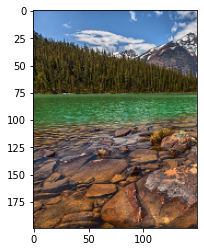

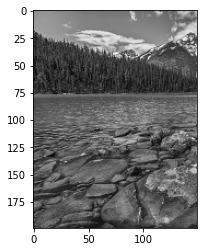

In [16]:
plt.imshow(coloring.left_actual)
plt.show()
plt.imshow(coloring.left_half, cmap="gray")
plt.show()

In [17]:
# Generating patches
patches = patchify(coloring.left_half, (3, 3))
# Flattening patches
patches = patches.reshape((-1, 9))
# Storing mid-points of each patch
patches_map = {}
count = 0
for i in range(1, coloring.left_half.shape[0] - 1):
    for j in range(1, coloring.left_half.shape[1] -1):
        patches_map[count] = (i, j)
        count += 1

In [18]:
coloring.right_half[0][0]

198.44

In [19]:
# Generating patches
right_patches = patchify(coloring.right_half, (3, 3))
# Flattening patches
right_patches = right_patches.reshape((-1, 9))
# Storing mid-points of each patch
right_patches_map = {}
count = 0
for i in range(1, coloring.right_half.shape[0] - 1):
    for j in range(1, coloring.right_half.shape[1] -1):
        right_patches_map[count] = (i, j)
        count += 1

In [20]:
from itertools import count
tiebreaker = count()

In [10]:
# Generating Tree
def make_kd_tree(points, dim, i=0):
    # Sorting points and using recursion to build a tree
    if len(points) > 1:
        points.sort(key=lambda x: x[i])
        i = (i + 1) % dim
        half = len(points) >> 1
        return [
            make_kd_tree(points[: half], dim, i),
            make_kd_tree(points[half + 1:], dim, i),
            points[half]
        ]
    elif len(points) == 1:
        return [None, None, points[0]]

In [41]:
# Generate K nearest neighbours given a tree root node
def get_knn(kd_node, point, k, dim, dist_func, return_distances=True, i=0, heap=None):
    # Using heap queue
    import heapq
    # Checking for root
    is_root = not heap
    if is_root:
        heap = []
    if kd_node is not None:
        # Calculating distance using given distance function
        dist = dist_func(point, kd_node[2])
        dx = kd_node[2][i] - point[i]
        # Using a continuous random number as a tiebreaker. Function collapses by searching array otherwise
        if len(heap) < k:
            heapq.heappush(heap, (-dist, next(tiebreaker), kd_node[2]))
        elif dist < -heap[0][0]:
            heapq.heappushpop(heap, (-dist, next(tiebreaker), kd_node[2]))
        i = (i + 1) % dim
        # Recursion by travelling through tree
        for b in [dx < 0] + [dx >= 0] * (dx * dx < -heap[0][0]):
            get_knn(kd_node[b], point, k, dim, dist_func, return_distances, i, heap)
    # Break condition
    if is_root:
        neighbors = sorted((-h[0], h[1]) for h in heap)
        return neighbors if return_distances else [n[1] for n in neighbors]

# Specifying patch size
dim = 9

# Using Euclidean distance
def dist_sq(a, b, dim):
    return sum((a[i] - b[i]) ** 2 for i in range(dim))

def dist_sq_dim(a, b):
    return dist_sq(a, b, dim)

In [21]:
from tqdm import tqdm

In [69]:
import pandas as pd
# pd.DataFrame(right_patches).to_csv("D:\\Study\\Intro_AI\\Coloring_Assignment\\patches/right_patches.csv", index=False)

In [70]:
# df = pd.read_csv('D:\\Study\\Intro_AI\\Coloring_Assignment\\patches/patches.csv')
# print(np.array(df))
# patches

In [71]:
sc_tree = make_kd_tree(list(patches), 9)

In [72]:
neighs = []
for pt in tqdm(right_patches):
    neighs.append(get_knn(sc_tree, list(pt), 6, dim, dist_sq_dim))

In [9]:
nbrs = NearestNeighbors(n_neighbors=6).fit(patches)


In [10]:
distances, nearest_neighbours = nbrs.kneighbors(right_patches, 10, return_distance=True)


In [40]:
# pt = right_patches[1]
# near_neigh = []
# for pt in tqdm(right_patches):
#     all_dist = {}
#     for i, patch in enumerate(patches):
#         dist = np.linalg.norm(patch-pt)
#         all_dist[i] = dist
#     min_index = min(all_dist, key=all_dist.get)
#     near_neigh.append(min_index)
# print(np.array(near_neigh))

In [11]:
import numpy_indexed as npi

In [12]:
coloring.right_actual_shape

(199, 150, 3)

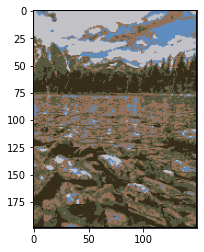

In [13]:
colored_right = np.zeros(coloring.right_actual_shape)
count = 0
for neighbours in nearest_neighbours:
    colors = []
    for neighbour in neighbours:
        colors.append(colored_left[patches_map[neighbour]])
    color = npi.mode(colors, return_indices= False)
    colored_right[right_patches_map[count][0]][right_patches_map[count][1]] = color
    count += 1
plt.imshow(colored_right / 255)
plt.show()


In [50]:
plt.imsave('D:\\Study\\Intro_AI\\Coloring_Assignment\\Images\\colored_right_10n.png', colored_right/255)

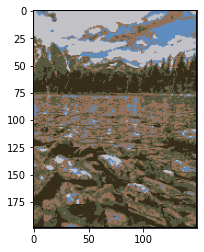

In [14]:
plt.imshow(colored_right / 255)
plt.show()

In [22]:
# Making patches again. With larger shape.
patches = patchify(coloring.left_half, (7, 7))
patches = patches.reshape((-1, 49))
# Storing mid points of each patch
patches_map = {}
count = 0
for i in range(1, coloring.left_half.shape[0] - 5):
    for j in range(1, coloring.left_half.shape[1] -5):
        patches_map[count] = (i, j)
        count += 1

print(count)

27792


In [23]:
# Generating patches for right half
right_patches = patchify(coloring.right_half, (7, 7))
right_patches = right_patches.reshape((-1, 49))
right_patches_map = {}
count = 0
for i in range(1, coloring.right_half.shape[0] - 5):
    for j in range(1, coloring.right_half.shape[1] -5):
        right_patches_map[count] = (i, j)
        count += 1

In [24]:
# Generating train and test data. X is grey scale left half patches
X_train = patches
# Each y is color for the mid point of the respective patch
Y_train = []
for i in range(len(patches_map.keys())):
    Y_train.append(coloring.left_actual[patches_map[i]])
print(len(Y_train))

27792


In [25]:
# Generating test Y from actual colors from right half
Y_test = []
for i in range(len(right_patches_map.keys())):
    Y_test.append(coloring.right_actual[right_patches_map[i]])
print(len(Y_test))

27792


In [29]:
import Regression
# By default returns training error. Takes X and Y image_part as input
def get_error(weights ,X_matrix=None, Y_matrix=None):
    # If no image_part given, calculating training error
    # mean-centering
        # Mean centering any input image_part as we've found weights after this
    X_matrix = Regression.mean_center_normalize(X_matrix, X_matrix.shape[0])

        # Y_matrix = Y_matrix[:, np.newaxis]
    Y_matrix = Y_matrix

    # Using the formula to find Y values. Bias is the first weight. X has 1s in the first column
    y_pred = X_matrix @ weights
    # Returning scaled score for better understanding. Error is squashed between 0 and 1
    # Example: Error of 0.1 is less. Error of 0.9 is terrible
    score = (((Y_matrix - y_pred) ** 2).sum() / ((Y_matrix - Y_matrix.mean()) ** 2).sum())
    return score

In [27]:
# Importing Regression from py file
from Regression import LinearRegression

# Initiating regression with learning rate and iterations
regressor = LinearRegression(X_train, np.asarray(Y_train), 0.01,
                                 tot_iterations=2000)
# regressor.fit_linear_reg_gradient(None, right_patches, np.asarray(Y_test))
# Fitting linear gradient descent
regressor.fit_ridge_reg(0.05)
# Getting scaled training error
regressor.get_error()

0.201527731936275

In [45]:
import plotly.graph_objects as go
import pandas as pd
cols=['iterations', 'train_error', 'test_error']
data= pd.read_csv("D:\\Study\\Intro_AI\\Coloring_Assignment\\Coloring_Project\\Regression_errors.txt",usecols=cols)
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=data['iterations'],
        y=data['train_error'],
        name = 'Train Error'
    ))

fig.add_trace(
    go.Scatter(
        x=data['iterations'],
        y=data['test_error'],
        name = 'Test Error'
    ))


fig.update_layout(
    title="Iterations- Error plot",
    xaxis_title="Iterations",
    yaxis_title="Scaled Error",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

In [30]:
get_error(regressor.weights, right_patches, np.array(Y_test))

0.1882605243005584

In [49]:
# pd.DataFrame(X_train).to_csv('D:\\Study\\Intro_AI\\Coloring_Assignment\\patches/X_train.csv', index=False)
# pd.DataFrame(np.array(Y_train)).to_csv('D:\\Study\\Intro_AI\\Coloring_Assignment\\patches/Y_train.csv', index=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


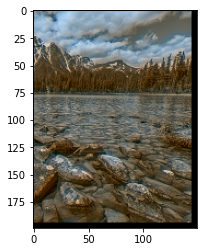

In [32]:
# Predict colors for right patches from the regression model
right_predicted = regressor.predict(right_patches)
# Initializing a empty array with actual right half shape
colored_right = np.zeros(coloring.right_actual_shape)
count = 0
for color in right_predicted:
    colored_right[right_patches_map[count][0]][right_patches_map[count][1]] = color
    count += 1
plt.imshow(colored_right / 255)
plt.show()

In [51]:
plt.imsave('D:\\Study\\Intro_AI\\Coloring_Assignment\\Images\\regression_7_patches.png', colored_right.clip(min=0))


Now Neural Networks

In [33]:
import Sample_NN as my_NN

In [34]:
Y_train = np.array(Y_train)

In [37]:
layer_sizes = [49, 10, 10, 1]  # set layer sizes, do not change the size of the first and last layer
num_iters = 1500  # set number of iterations over the training set(also known as epochs in batch gradient descent context)
learning_rate = 0.1  # set learning rate for gradient descent
red_params = my_NN.model(X_train, Y_train[:, 0], layer_sizes, num_iters, learning_rate)  # train the model
red_pred = my_NN.predict(right_patches, red_params)

Cost at iteration 1 = 5922.857693587433

Cost at iteration 101 = 5918.779863373718

Cost at iteration 201 = 5900.35249354247

Cost at iteration 301 = 828.3651962887905

Cost at iteration 401 = 764.9048109985029

Cost at iteration 501 = 704.5585465051122

Cost at iteration 601 = 646.2975489953934

Cost at iteration 701 = 596.9586468116737

Cost at iteration 801 = 561.2500146310921

Cost at iteration 901 = 534.5351575005454

Cost at iteration 1001 = 512.2152168458599

Cost at iteration 1101 = 493.101607904743

Cost at iteration 1201 = 477.0412426507556

Cost at iteration 1301 = 463.81598367429365

Cost at iteration 1401 = 453.05420192730094



In [38]:
green_params = my_NN.model(X_train, Y_train[:, 1], layer_sizes, num_iters, learning_rate)  # train the model
green_pred = my_NN.predict(right_patches, green_params)
blue_params = my_NN.model(X_train, Y_train[:, 2], layer_sizes, num_iters, learning_rate)  # train the model
blue_pred = my_NN.predict(right_patches, blue_params)

Cost at iteration 1 = 5541.059464340382

Cost at iteration 101 = 5529.300538268529

Cost at iteration 201 = 297.0572977936812

Cost at iteration 301 = 263.61872067251886

Cost at iteration 401 = 234.55657670566768

Cost at iteration 501 = 208.31888738233152

Cost at iteration 601 = 184.6794498115935

Cost at iteration 701 = 163.96322927054896

Cost at iteration 801 = 146.24239128658675

Cost at iteration 901 = 130.98273460686352

Cost at iteration 1001 = 117.47113423089571

Cost at iteration 1101 = 105.2877454028673

Cost at iteration 1201 = 94.33153248671404

Cost at iteration 1301 = 84.62668310395284

Cost at iteration 1401 = 76.17719268320221

Cost at iteration 1 = 5342.036405512969

Cost at iteration 101 = 5339.047074524648

Cost at iteration 201 = 5331.473409182514

Cost at iteration 301 = 784.0665190893677

Cost at iteration 401 = 764.1815132593347

Cost at iteration 501 = 747.8006916819169

Cost at iteration 601 = 733.7124239718149

Cost at iteration 701 = 721.394513750373

Cost

In [44]:
import pandas as pd
import plotly.graph_objects as go

cols=['iteration', 'cost']
data_red= pd.read_csv("D:\\Study\\Intro_AI\\Coloring_Assignment\\Coloring_Project\\NN_red_error.txt",usecols=cols)
data_green= pd.read_csv("D:\\Study\\Intro_AI\\Coloring_Assignment\\Coloring_Project\\NN_green_error.txt",usecols=cols)
data_blue= pd.read_csv("D:\\Study\\Intro_AI\\Coloring_Assignment\\Coloring_Project\\NN_blue_error.txt",usecols=cols)
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=data_red['iteration'],
        y=data_red['cost'],
        name = 'Red Error'
    ))

fig.add_trace(
    go.Scatter(
        x=data_green['iteration'],
        y=data_green['cost'],
        name = 'Green error'
    ))

fig.add_trace(
    go.Scatter(
        x=data_blue['iteration'],
        y=data_blue['cost'],
        name = 'Blue error'
    ))


fig.update_layout(
    title="Iterations- Cost plot",
    xaxis_title="Iterations",
    yaxis_title="Cost",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

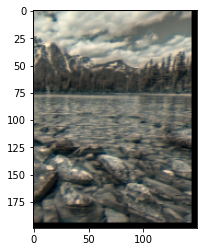

In [58]:
mixed = np.concatenate([red_pred, green_pred, blue_pred], axis= 1)
colored_right = np.zeros(coloring.right_actual_shape)
count = 0
for color in mixed:
    colored_right[right_patches_map[count][0]][right_patches_map[count][1]] = color
    count += 1
colored_right = colored_right.clip(min=0).clip(max = 255)
plt.imshow(colored_right / 255)
plt.show()

In [59]:
plt.imsave('D:\\Study\\Intro_AI\\Coloring_Assignment\\Images\\NN_Colored.png', colored_right/255)

In [19]:
colored_right

NameError: name 'colored_right' is not defined

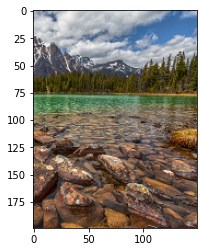

In [56]:
plt.imshow(coloring.right_actual / 255)
plt.show()